# Adding Static Wake to TurbSim output

This notebook is about to adding the static wake to Turbsim outputs. The motivation here is modeling a turbine (NREL5MW) in the wake without going through the hassle of dynamic wake modeling. This is work is mainly basd on the section 4 of HIPERWIND report "Wind farm parameterization and turbulent wind box generation" (https://hal-lara.archives-ouvertes.fr/hal-04033050/), and "A new Gaussian-based analytical wake model for wind turbines considering ambient turbulence intensities and thrust coefficient effects" (https://doi.org/10.1016/j.jweia.2018.04.010). The modification on the Sobol's sampled $[u,TI,\alpha]$. The process is as follow:

- Take the Sobol's samples from the domains
- Calculate wake shape function $\phi$ and TI changes for each sample
- Calculate the harmonic mean of the velocity deficit $\phi$ over the rotor
- Calculate the mean of the TI changes over the rotor
- Generate TurbSim input files based on the calculated means ($\phi$ and TI).
- Run TurbSim
- Import the generated Turbsim '.bts' files, recall the wake shape function $\phi$ modify the turbulent wind box data
- Save the modified tubulent wind with the same file naming
- Generate Inflwo and OpenFAST input files and run the OpenFAST simulations.



## Importing python libraries

In [1]:
import os

#os.chdir('../../Colab_NB/NREL5MW_Sobol_uTIa_FFWind_ResNet/')
print(os.getcwd())

import numpy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import chaospy as cp
import glob

import time as tm

from scipy import signal
import datetime
import sys
from pyFAST.input_output import FASTOutputFile
from pyFAST.input_output import TurbSimFile
from pyFAST.input_output import FASTInputFile
from scipy.interpolate import interp2d
from scipy.stats import hmean

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path

timestr = tm.strftime('%Y%m%d')


import random

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size = 30)
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)
plt.rc('legend',fontsize=25) # using a size in points
plt.rc('axes', labelsize = 25)


/project/6002346/rhaghi/OpenFAST/NREL5MW_Sobol_u_alpha_TI_Wake_000m90m/_PythonCode


## Sobol's Sample function 

This function takes the number of samples is, and genrates Sobol's samples on $[u,TI,\alpha]$ based on the predifined bounderies. In the output sampling array, the first row is the
    wind speed, the second row is the shear $\alpha$ and the third row is TI 

In [2]:
def Sobol_Samp_u_a_TI(nos):
    a_LB = 0.15
    a_UB = 0.22
    D = 126
    R = D/2
    U_max = 25
    z = 90
    U = cp.Uniform(lower = 3, upper=25)
    TI = cp.Uniform(lower = 0.04, upper=0.18*(0.75+5.6/U))
    alpha_lb = a_LB-0.23*(U_max/U)*(1-(0.4*np.log10(R/z))**2)
    alpha_ub = a_UB + 0.4*(R/z)*(U_max/U)
    alpha = cp.Uniform(lower =alpha_lb , upper=alpha_ub)
    joint_dist1 = cp.J(U,alpha)
    joint_dist2 = cp.J(U,TI)
    joint_dist1_T = cp.Trunc(joint_dist1,lower=-0.3,upper=30)
    s1 = cp.generate_samples(nos, joint_dist1_T,rule='S')
    samp1 = s1[:,np.argsort(s1[0,:])]
    s2 = cp.generate_samples(nos, joint_dist2,rule='S')
    samp2 = s2[:,np.argsort(s2[0,:])]
    '''Stack alpha and TI together. In the main sampling array, the first row is the
    wind speed, the second row is the shear (alpha) and the third row is TI 
    '''
    samp = np.vstack((samp1,samp2[1,:]))
    return samp

## Wake shape function, and $\Delta TI$

From [1]"A new Gaussian-based analytical wake model for wind turbines considering ambient turbulence intensities and thrust coefficient effects" (https://doi.org/10.1016/j.jweia.2018.04.010) and [2] Wind farm parameterization and turbulent wind box generation" (https://hal-lara.archives-ouvertes.fr/hal-04033050/).

In [3]:
def sigma_D(x,D,I_a,Ct):
    #From Eq 28 of [1]:
    k_star= 0.11*(Ct**1.07)*(I_a**0.2)
    epsilon = 0.23*(Ct**(-0.25))*(I_a**0.2)
    #From Eq 24 of [1]:
    sD = k_star*x/D + epsilon
    return sD

def vel_def(Ct,sigma_D):
    #From Eq 5 of [2]
    vd = (1-np.sqrt(1-Ct/(8*(sigma_D**2))))
    return vd

def get_phi(y,y_wake,z,z_hub,u_0,alpha,vel_def,sigma_D,D):
    #From Eq 4 of [2]
    u=u_0*(z/z_hub)**alpha
    sigma = sigma_D*D
    gauss_power = (-1/(sigma**2))*((z-z_hub)**2+(y-y_wake)**2)
    guassian = vel_def*np.exp(gauss_power)
    phi_yz = u*(1-guassian)
    return phi_yz

def delta_I(x,y,z,HH,D,I_a,Ct,sigma_D):
    # From Eq 35 of [1] and formulas in Table 2
    sgm = sigma_D*D
    pi = np.pi
    r = np.sqrt(y**2 + (z-HH)**2)
    d = 2.3*Ct**(-1.2)
    e = I_a**(0.1)
    f = 0.7*Ct**(-3.2)*I_a**(-0.45)
    k1=np.nan
    k2=np.nan
    if r/D <= 0.5:
        k1 = np.cos((pi/2)*(r/D-0.5))**2
    elif r/D > 0.5:
        k1 =1
    if r/D <= 0.5:
        k2 = np.cos((pi/2)*(r/D+0.5))**2
    elif r/D > 0.5:
        k2 =0
    if z>=HH:
        drk = 0
    elif z<HH:
        drk = I_a*np.sin(pi*(HH-z)/HH)
        #drk = 0
    frc1 = 1/(d+e*x/D+f*(1+x/D)**(-2))
    frc2 = -((r-D/2)**2)/(2*sgm**2)
    frc3 = -((r+D/2)**2)/(2*sgm**2)
    d_I1 = frc1*(k1*np.exp(frc2) + k2*np.exp(frc3)) - drk
    return d_I1

## Reading the $C_{t}$ for NREL 5MW turbine.

I downloaded this CSV file from (https://github.com/NREL/turbine-models/blob/master/Offshore/NREL_5MW_126_RWT.csv). I am not sure about the $C_t$ values for the lower wind speeds.

In [4]:
NREL_5MW_Ct = pd.read_csv('NREL_Ct.csv')
NREL_5MW_Ct=NREL_5MW_Ct.drop(labels=0,axis=0)
NREL_5MW_Ct = NREL_5MW_Ct.astype(float)

D = 126     #Rotor diameter [m]

## Generating the Sobol's samples for $n$ 

We are going for $n=2^{11}$ samples.

In [5]:
NS = 2**11
samp = Sobol_Samp_u_a_TI(NS)
sobol_samps = pd.DataFrame(data = samp.T,columns=['u','alpha','TI'])


## Read the sample BTS file to have the nodes y,z locations 

I copied one bts file from the precious case to have the grid points as they are needed to calculate $\phi$ and $TI$. Afterwards, I exported the y and z locations for the grids.

In [6]:
InitialOutput = TurbSimFile('90m_03p06646mps_ti_00p10314_alp_00p11765_000100.bts')
y = InitialOutput['y']
z = InitialOutput['z']

# making mesh using y,z for plotting and averaging purposes
Y,Z= np.meshgrid(y,z)

## Find the mask on the rotor to calculate the means

As we said before, we need to calculate the harmonic meand for the wake shape function, and mean for the $\Delta TI$. Here we find a mask, that is the same size as the grid, and tell us which grid points lay in the rotor.

In [7]:
rotor_center = (0, 90)
rotor_radius = D/2

# Mask to select points inside the circle
inside_rotor_mask = (Y - rotor_center[0])**2 + (Z - rotor_center[1])**2 <= rotor_radius**2

## Using the generated samples from Sobol's to calculate the wake shape function $\phi$ and $\Delta TI$

To this point we geneated the samples, now with this data we can calculate the wake shape function and changes in TI. Then the means are saved in a dataframe and saved. As in TurbSim we don't have control on mean wind speed and TI per grid point, we calculate the harmonic mean and average over the rotor and use them to generate turbsim data files. This is based on [2], section 4.4.2.

In [8]:
modified_sobol = pd.DataFrame(columns=['u','alpha','TI','Seed Number'])

x = 7*D     #Distance down the first turbine
y_wake = 0  #The center of the wake y
z_hub = 90  #Hub height


for (u,a,ti,s) in zip(samp[0,:],samp[1,:],samp[2,:],range(1,NS+1)):
    # Find the corresponding Ct for the wind speed
    Ct = NREL_5MW_Ct.loc[NREL_5MW_Ct['WindVxi']==np.round(u)]['Ct'].to_numpy()
    # The wake width based on the linear wake propogation
    S_ovr_D = sigma_D(x=x,D=D,I_a=ti,Ct=Ct)
    # The maximum velocity defici
    vd = vel_def(Ct,S_ovr_D)
    phi = np.zeros((15,15))
    dI1 = np.zeros((15,15))
    for i,y_i in zip(range(0,15),y):
        for j,z_i in zip(range(0,15),z):
            #print(y_i,z_i)
            phi[j,i] = get_phi(y_i,y_wake,z_i,z_hub,u,a,vel_def=vd,sigma_D=S_ovr_D,D=D)
            dI1[j,i] = delta_I(x,y_i,z_i,z_hub,D,ti,Ct,S_ovr_D)
    hmean_rotor_phi = hmean(phi[inside_rotor_mask])
    mean_rotor_dI1 = np.mean(dI1[inside_rotor_mask])
    df_temp = pd.DataFrame(data = np.array([hmean_rotor_phi,a,ti+mean_rotor_dI1,s]).reshape(1,-1),columns=['u','alpha','TI','Seed Number'])
    modified_sobol = pd.concat([modified_sobol,df_temp],axis=0,ignore_index = True)
    
modified_sobol.astype({'Seed Number': 'int32'})
modified_sobol.to_csv('mod_sobol.csv')

## Generating the turbsim input files for the modified Sobol's samples

Now, we have the Sobol's samples modified, we can generate the turbsim input files

In [9]:

TrasTime = 120
SimLength = np.array([600])

DecInFN = 5 #Decimal in file naming

SeedNo = np.arange(1,NS+1)

def DeciToStr(x,zfl_x,zfl_d):
    n = np.trunc(x).astype(int)
    ndci = np.abs(x-n)
    if x<0:
        n_str = 'n'+str(np.abs(n)).zfill(zfl_x-1)
    else:
        n_str = str(n).zfill(zfl_x)
    ndci_str = str(int(ndci*np.power(10,zfl_d))).zfill(zfl_d) 
    return n_str,ndci_str



TurbSimInputTemp = "../TurbSim/_Template/HH_UREFmps_SeedNo.inp"
fTurbSimInput = FASTInputFile(TurbSimInputTemp)
#TurbSimExeFile = "turbsim"
#TurbSimBatFile = "../TurbSim/"+timestr+'_TurbSimBatFile.sh'
#fTurbSimBatFile = open(TurbSimBatFile,"w")
#fTurbSimBatFile.write("#!/bin/bash\n") 

for uats in zip(modified_sobol.to_numpy(),SeedNo):    
    fTurbSimInput = FASTInputFile(TurbSimInputTemp)
    fTurbSimInput['URef'] = uats[0][0]
    fTurbSimInput['RandSeed1'] = uats[1].astype(int)
    fTurbSimInput['NumGrid_Z'] = int(15)
    fTurbSimInput['NumGrid_Y'] = int(15)
    fTurbSimInput['AnalysisTime'] = int(SimLength+TrasTime)
    fTurbSimInput['WrADHH'] = 'False'
    fTurbSimInput['IECturbc'] = uats[0][2]*100
    fTurbSimInput['PLExp'] = uats[0][1]
    u_n, u_dec = DeciToStr(uats[0][0],2,DecInFN)
    TI_n, TI_dec = DeciToStr(uats[0][2],2,DecInFN)
    a_n, a_dec = DeciToStr(uats[0][1],2,DecInFN)
    TurbSimInputFileName =str(z_hub)+'m_'+u_n+'p'+u_dec+'mps_ti_'+TI_n+'p'+TI_dec+'_alp_'+a_n+'p'+a_dec+'_'+str(uats[1].astype(int)).zfill(6)+'.inp'
    fTurbSimInput.write("../TurbSim/"+TurbSimInputFileName)
            


## Generating the Inflow input files

The inflow files are necessary to introduce turbsim outputs to OpenFAST

In [10]:
InflowInputTemp = "../Inflow/_Template/NRELOffshrBsline5MW_InflowWind_XXmps.dat" 

InflowFileNameList={}

for uats in zip(modified_sobol.to_numpy(),SeedNo):    
    fInflowInput = FASTInputFile(InflowInputTemp)
    fInflowInput['m/s'] = uats[0][0]
    u_n, u_dec = DeciToStr(uats[0][0],2,DecInFN)
    TI_n, TI_dec = DeciToStr(uats[0][2],2,DecInFN)
    a_n, a_dec = DeciToStr(uats[0][1],2,DecInFN)
    BTSFileName =str(z_hub)+'m_'+u_n+'p'+u_dec+'mps_ti_'+TI_n+'p'+TI_dec+'_alp_'+a_n+'p'+a_dec+'_'+str(uats[1].astype(int)).zfill(6)+'.bts'
    fInflowInput['WindType']= 3
    fInflowInput['FileName_BTS'] = '"../TurbSim/'+BTSFileName+'"'
    InflowFileName = "NREL5MW_InflowWind_"+u_n+'p'+u_dec+'mps_ti_'+TI_n+'p'+TI_dec+'_alp_'+a_n+'p'+a_dec+'_'+str(uats[1].astype(int)).zfill(6)+'.dat'
    fInflowInput.write("../Inflow/"+InflowFileName)

## Generating OpenFAST input files

Everything is ready for this!

In [11]:
DLC = 'DLC12'
WindDir =0
WaveDir = 0
SimLength = 600
TrasTime = 120
dt= 0.05/8
dt_out = 0.05

FASTTemp = "../Sims/_Template/5MW_Land_DLL_WTurb.fst"
fFASTTemp = FASTInputFile(FASTTemp)
SimFolder = '../Sims/DLC12_NREL5MW'+'_'+str(WindDir).zfill(3)+'_'+str(WaveDir).zfill(3)+'_'+str(SimLength).zfill(3)+'s'

if  os.path.exists(SimFolder) == False:
    os.mkdir(SimFolder)

for uats in zip(modified_sobol.to_numpy(),SeedNo):    
    fFASTTemp = FASTInputFile(FASTTemp)
    u_n, u_dec = DeciToStr(uats[0][0],2,DecInFN)
    TI_n, TI_dec = DeciToStr(uats[0][2],2,DecInFN)
    a_n, a_dec = DeciToStr(uats[0][1],2,DecInFN)
    fFASTTemp['DT']=dt
    fFASTTemp['TMax']=SimLength+TrasTime
    fFASTTemp['InflowFile']='"../../Inflow/'+"NREL5MW_InflowWind_"+u_n+'p'+u_dec+'mps_ti_'+TI_n+'p'+TI_dec+'_alp_'+a_n+'p'+a_dec+'_'+str(uats[1].astype(int)).zfill(6)+'.dat"'
    fFASTTemp['TStart'] = TrasTime
    fFASTTemp['DT_Out'] = dt_out
    if uats[0][0] > 19:
        fFASTTemp['EDFile']= '"NRELOffshrBsline5MW_Onshore_ElastoDyn_Pitch20deg.dat"'
    FASTFileName = 'NREL5MW_'+DLC+'_'+u_n+'p'+u_dec+'mps_ti_'+TI_n+'p'+TI_dec+'_alp_'+a_n+'p'+a_dec+'_'+str(WindDir).zfill(3)+'_'+str(WaveDir).zfill(3)+'_'+str(uats[1].astype(int)).zfill(6)+'.fst'
    fFASTTemp.write(SimFolder+'/'+FASTFileName)

## Generating the SH files to submit to the queue

We have generated the input files for Turbsim and OpenFAST. Now, here we put them in the SH files, in this order per simulation case:

- TurbSim
- Python code to add static wake to generated TurbSim
- OpenFAST

This should better work! I am done with this shit!

In [15]:
files_fst=[]

for file in glob.glob(SimFolder+'/*.fst'):
    files_fst.append(file)

files_fst.sort()


files_inp=[]

for file in glob.glob("../TurbSim/*.inp"):
    files_inp.append(file)

files_inp.sort()






#%%    
FASTExeFile = "openfast"
TurbSimExeFile = "turbsim"
PythinExeFile = "python"
StaticWake_Python = "../_PythonCode/StaticWake_BTSModifier.py"

NoFiles = 16
TotalNum = NS
it_steps = np.arange(0,TotalNum+1,NoFiles)
#it_steps = np.append(it_steps,nos)

m=0
#%%
for i in range(1,it_steps.size):
    FASTBatFile = '../Sims/'+str(i).zfill(4)+'of'+str(it_steps.size-1).zfill(4)+'_NREL5MW_sims'+'.sh'
    fFASTBatFile = open(FASTBatFile,"w")
    fFASTBatFile.write("#!/bin/bash\n")
    fFASTBatFile.write("#SBATCH --account=def-curranc\n")
    fFASTBatFile.write("#SBATCH --mem-per-cpu=4G      # increase as needed\n")
    fFASTBatFile.write("#SBATCH --time=24:00:00\n")
    fFASTBatFile.write("module load StdEnv/2020  intel/2020.1.217 openfast/3.1.0\n")  
    fFASTBatFile.write("source $HOME/jupyter_py3/bin/activate \n")  
    for j in range(it_steps[i-1],it_steps[i]):
        bts_file = files_inp[j][0:files_inp[j].find('.inp')]+'.bts'
        fFASTBatFile.write(TurbSimExeFile+' '+files_inp[j]+'\n')
        fFASTBatFile.write(PythinExeFile+' '+ StaticWake_Python+' '+bts_file+' '+str(y_wake)+'\n')
        fFASTBatFile.write(FASTExeFile+' '+files_fst[j][8:]+'\n')
        m=m+1
    fFASTBatFile.write('rm ../TurbSim/*.sum'+ '\n')    
    fFASTBatFile.close()                                      

#%%

os.chdir('../Sims/')

files=[]

for file in glob.glob("*.sh"):
    files.append(file)
    
    
files.sort()

sbatch_file = timestr+'_SHELLofshell.sh'
sbatch ='sbatch'
sbatchf = open(sbatch_file,'w')



for f in files:
    sbatchf.write(sbatch+' '+f+'\n')

sbatchf.close()

os.chdir('../_PythonCode')    


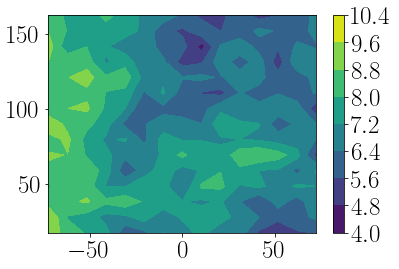

In [13]:
TestWake = TurbSimFile('../TurbSim/90m_07p15283mps_ti_00p16041_alp_n0p13737_000498.bts')
y = TestWake['y']
z = TestWake['z']

# making mesh using y,z for plotting and averaging purposes
Y,Z= np.meshgrid(y,z)

plt.contourf(Y,Z,TestWake['u'][0,int(320/0.05),:,:])
plt.colorbar()